# Source Reconstruction


In [2]:
# Setup and imports
import os.path as op
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import mne_connectivity
import numpy as np
import pandas as pd
from IPython.display import clear_output
from mne_connectivity import envelope_correlation
from tqdm.auto import tqdm


In [2]:
# Helper functions
def creat_raw_from_epochs(epochs):
    data = np.hstack(epochs.get_data())
    info = mne.create_info(ch_names=epochs.ch_names,
                           ch_types='eeg',
                           sfreq=epochs.info['sfreq'])

    raw = mne.io.RawArray(data, info)
    raw.set_channel_types({'ECG': 'ecg', 'EOG1': 'eog', 'EOG2': 'eog'})
    return raw

def make_forward():
    # fsaverage files
    fs_dir = Path('data/fsaverage')

    # The files live in:
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = fs_dir / 'bem' / 'fsaverage-ico-4-src.fif' # use icosahedron4 with 6.2 mm source spacing
    src = mne.read_source_spaces(src)
    bem = fs_dir / 'bem' / 'fsaverage-5120-5120-5120-bem-sol.fif'
    
    path:Path = Path('data/clean_data')
    epochs_fname = path / 'sub-01_ses-01_task-baseline1_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)

    # create raw object
    raw = creat_raw_from_epochs(epochs)

    # insert channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # forward solution (the same across all subjects)
    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=-1, verbose=False)
    del src, bem
    return fwd

def make_inverse_4baseline(subject: str,
                           fwd: mne.forward.forward.Forward,
                           path = Path('data/clean_data')):
    
    epochs_fname = path / f'{subject}_ses-01_task-baseline1_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)
    
    # create raw object
    raw = creat_raw_from_epochs(epochs)

    # insert channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    raw.set_eeg_reference('average', projection=True)
    
    # covariance matrix
    cov = mne.compute_raw_covariance(raw, method='auto', cv=5, n_jobs=-1)

    # inverse operator
    inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, verbose=False)
    
    return inv

def get_connectivity(subject: str,
                     task: str,
                     atlas_labels: list,
                     inv: mne.minimum_norm.inverse.InverseOperator,
                     path:Path = Path('data/clean_data')):
    # open data
    epochs_fname = path / f'{subject}_ses-01_task-{task}_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)

    stc = mne.minimum_norm.apply_inverse_epochs(epochs,
                                                inv,
                                                method='eLORETA',
                                                lambda2=1./9.,
                                                verbose=False)
    
    
    label_ts = mne.extract_label_time_course(stc,
                                             atlas_labels,
                                             inv['src'],
                                             return_generator=False,
                                             verbose=False)
    
    conn_obj = envelope_correlation(label_ts, orthogonalize='pairwise')
    conn = conn_obj.combine()
    conn = conn.get_data(output='dense')[..., 0]
    
    return conn

# Forward and Inverse Model

In [8]:
# we will use Yeo2011 atlas
atlas_labels = mne.read_labels_from_annot('fsaverage',
                                          'Yeo2011_17Networks_N1000',
                                          subjects_dir='data/')

# forward solution (same across all subjects)
fwd = make_forward()

for subject_path in sorted(Path('data/clean_data').glob('*.fif')):

    subject, task = re.search('(.*)_ses.*_task-(.*)_proc.*', subject_path.stem).groups()
    
    output_path = Path(f'data/connectivities/{subject}_task-{task}_conn-corr.npz')
    
    if output_path.exists():
        continue
        
    print('>>>>>>>>', subject, task)
    if task == 'baseline1':
        inv = make_inverse_4baseline(subject, fwd)
        
    elif 'induction' in task or task == 'baseline2':
        continue
    
    else: 
        conn = get_connectivity(subject, task, atlas_labels, inv)
        np.savez(output_path, conn=conn)

    clear_output()

>>>>>>>> sub-52 induction1
>>>>>>>> sub-52 induction4


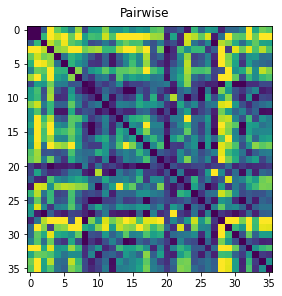

In [25]:
# visualization
def plot_corr(corr, title):
    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
    fig.suptitle(title)


plot_corr(conn, 'Pairwise')

## Prepare data for Classification

In [120]:
# create labels
# yeo2011 networks names
yeo = {
    'N1': 'Visual oeripheral',
    'N2': 'Visual central',
    'N3': 'Somatomotor A',
    'N4': 'Somatomotor B',
    'N5': 'Dorsal attention A',
    'N6': 'Dorsal attention B',
    'N7': 'Ventral attention',
    'N8': 'Salience',
    'N9': 'Limbic A',
    'N10': 'Limbic B',
    'N11': 'Control C',
    'N12': 'Control A',
    'N13': 'Control B',
    'N14': 'Default D (Auditory)',
    'N15': 'Default C',
    'N16': 'Default A',
    'N17': 'Default B',
 }

atlas_orders = [str(atlas_labels[i]).split("'")[1].split("_")[1]
 for i in range(len(atlas_labels[:-2]))]

labels = [f'N{atlas_orders[i]}'+'_'+yeo[f'N{atlas_orders[i].split("-")[0]}']  for i in range(len(atlas_orders))]

conn_labels = pd.DataFrame(columns=labels, index=labels)
conn_labels = conn_labels.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]

In [121]:
# initiate an empty df
conn_df_total = pd.DataFrame()

# open data
for subject_path in sorted(Path('data/connectivities').glob('*.npz')):

    subject, task = re.search('(.*)_task-(.*)_conn-corr.*', subject_path.stem).groups()
    
    conn = np.load(f'data/connectivities/{subject}_task-{task}_conn-corr.npz')['conn'][:-2, :-2]
    conn_flat = conn[np.triu_indices(conn.shape[-1], k=0)]
    conn_df = pd.DataFrame(conn_flat, index=conn_labels).transpose()
    conn_df_total = pd.concat([conn_df_total, conn_df], axis=0)

subjects = [f'{i:02}' for i in range(1, 53)]
tasks = [
'experience1',
'experience2',
'experience3',
'experience4'
  ]    
# set index
index = []
[index.append(sub + '_' + cond) for sub in subjects for cond in tasks ]
[index.remove(i) for i in ['52_experience2', '52_experience3']]
conn_df_total = conn_df_total.set_axis(index)

In [122]:
# open behavioral data and ids map
bh = pd.read_csv('docs/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
bh = bh.join(ids_map, how='right')
bh = bh.melt(
    id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
             'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
    value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
bh = bh.rename(columns={'value':'hypnosis_depth'})
bh.reset_index(inplace=True)
bh.head()

,bids_id,hypnosis_depth,procedure,description,session
0,01,6.0,whitenoise,hypnosis,1
1,01,7.0,relaxation,control,2
2,01,8.0,confusion,hypnosis,3
3,01,1.0,embedded,control,4
4,02,1.0,relaxation,control,1


In [123]:
conn_df_total[['bids_id', 'condition']] = conn_df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
conn_df_total['session'] = conn_df_total['condition'].apply(lambda x:x[-1])
conn_df_total.reset_index(drop=True, inplace=True)
conn_df_total = pd.merge(bh, conn_df_total, how='right', on=['session', 'bids_id'], right_index=False)
conn_df_total = conn_df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
conn_df_total.insert(1, 'condition', conn_df_total.pop('condition'))
conn_df_total.to_csv('data/YeoNets_classification.csv')
conn_df_total.head()


,bids_id,condition,hypnosis_depth,procedure,description,session,N1-lh_Visual oeripheral ↔ N1-lh_Visual oeripheral,N1-lh_Visual oeripheral ↔ N1-rh_Visual oeripheral,N1-lh_Visual oeripheral ↔ N10-lh_Limbic B,N1-lh_Visual oeripheral ↔ N10-rh_Limbic B,...,N8-lh_Salience ↔ N8-lh_Salience,N8-lh_Salience ↔ N8-rh_Salience,N8-lh_Salience ↔ N9-lh_Limbic A,N8-lh_Salience ↔ N9-rh_Limbic A,N8-rh_Salience ↔ N8-rh_Salience,N8-rh_Salience ↔ N9-lh_Limbic A,N8-rh_Salience ↔ N9-rh_Limbic A,N9-lh_Limbic A ↔ N9-lh_Limbic A,N9-lh_Limbic A ↔ N9-rh_Limbic A,N9-rh_Limbic A ↔ N9-rh_Limbic A
0,01,experience1,6.0,whitenoise,hypnosis,1,0.0,0.086846,0.101730,0.146474,...,0.0,0.100776,0.112426,0.083473,0.0,0.110187,0.111738,0.0,0.120478,0.0
1,01,experience2,7.0,relaxation,control,2,0.0,0.089829,0.104836,0.145859,...,0.0,0.093205,0.105723,0.102145,0.0,0.107773,0.099963,0.0,0.110278,0.0
2,01,experience3,8.0,confusion,hypnosis,3,0.0,0.111414,0.106726,0.136119,...,0.0,0.100158,0.112084,0.088994,0.0,0.111839,0.103106,0.0,0.123121,0.0
3,01,experience4,1.0,embedded,control,4,0.0,0.078402,0.102966,0.168922,...,0.0,0.094078,0.132116,0.086217,0.0,0.111434,0.092466,0.0,0.150102,0.0
4,02,experience1,1.0,relaxation,control,1,0.0,0.078842,0.106373,0.221509,...,0.0,0.102378,0.151526,0.109173,0.0,0.103267,0.096367,0.0,0.127198,0.0
